In [1]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from ipynb.fs.full.preProcess import basic_preProcess, color_preProcess, augment_contrast
from tensorflow.keras.callbacks import EarlyStopping


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate

from keras.utils.vis_utils import plot_model

In [2]:
# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

train_dir = './processed_train/color/'
# test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [3]:
train_data_color = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

"""
1. train_data_color: Daftar yang akan menyimpan gambar untuk pelatihan berdasarkan warna.
2. train_jenis: Daftar untuk menyimpan label jenis dari setiap gambar.
3. train_warna: Daftar untuk menyimpan label warna dari setiap gambar.
4. test_data: Daftar yang dapat digunakan untuk menyimpan data pengujian.
5. test_ids: Daftar untuk menyimpan ID dari gambar di test_data.
"""

input_shape = (224, 224, 3)

"""
input_shape: Menentukan dimensi input untuk model, di mana gambar akan diubah ukurannya menjadi 224x224 piksel dengan 3 saluran warna (RGB).
"""

for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):
          train_data_color.append(img)

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])

        else:
          print("no image found")

"""
Kode ini melakukan iterasi pada setiap item dalam direktori train_dir:
os.listdir(train_dir): Mengambil daftar semua file dalam direktori pelatihan.
cv.imread(img_path): Membaca gambar dari jalur yang ditentukan (img_path).
Jika gambar berhasil dibaca (img is not None), gambar ditambahkan ke train_data_color.

Menentukan Label:
Kondisi cond digunakan untuk menemukan baris dalam DataFrame train_df yang memiliki ID yang sama dengan nama file gambar (dihapus ekstensi).
Mengambil label jenis dan warna berdasarkan indeks dari DataFrame dan menambahkannya ke daftar yang sesuai.
Jika gambar tidak ditemukan, pesan "no image found" akan di print.
"""

xtrain_warna, xval_warna, ytrain_warna, yval_warna = train_test_split(
    train_data_color, train_warna,
    test_size=0.2, random_state=42,
    stratify=train_warna
)

"""
train_test_split: Fungsi ini membagi train_data dan label warna menjadi set pelatihan dan validasi:
train_data_color: Data gambar yang akan dibagi.
train_warna: Label warna yang akan dibagi.
test_size=0.2: 20% dari data akan digunakan untuk validasi.
random_state=42: Menetapkan nilai seed untuk memastikan hasil yang dapat direproduksi.
stratify=train_warna: Memastikan distribusi kelas yang seimbang untuk label warna dalam data pelatihan dan validasi.
"""

'\ntrain_test_split: Fungsi ini membagi train_data dan label warna menjadi set pelatihan dan validasi:\ntrain_data_color: Data gambar yang akan dibagi.\ntrain_warna: Label warna yang akan dibagi.\ntest_size=0.2: 20% dari data akan digunakan untuk validasi.\nrandom_state=42: Menetapkan nilai seed untuk memastikan hasil yang dapat direproduksi.\nstratify=train_warna: Memastikan distribusi kelas yang seimbang untuk label warna dalam data pelatihan dan validasi.\n'

In [4]:
# augment
max_len = len(xtrain_warna)
for img_raw, warna in zip(xtrain_warna[:int(max_len*0.75)],ytrain_warna[:int(max_len*0.75)]):
   if warna not in [3]:
      xtrain_warna.append(augment_contrast(img_raw))
      ytrain_warna.append(warna)


"""
Augmentasi Gambar
Kode ini melakukan iterasi pada gambar dan label warna:
zip(xtrain_warna[:int(max_len*0.75)], ytrain_warna[:int(max_len*0.75)]): Mengambil 75% pertama dari xtrain_warna dan ytrain_warna untuk diproses.
if warna not in [3]: Memeriksa apakah label warna tidak sama dengan 3. Jika tidak sama dengan 3, gambar akan diaugmentasi.
xtrain_warna.append(augment_contrast(img_raw)): Fungsi augment_contrast(img_raw) digunakan untuk meningkatkan kontras gambar img_raw, dan hasilnya ditambahkan ke daftar xtrain_warna.
ytrain_warna.append(warna): Label warna yang sama ditambahkan ke daftar ytrain_warna.
Dengan langkah ini, dataset pelatihan akan diperluas dengan gambar yang telah diaugmentasi, sehingga meningkatkan keberagaman data yang digunakan untuk pelatihan model.

"""

'\nAugmentasi Gambar\nKode ini melakukan iterasi pada gambar dan label warna:\nzip(xtrain_warna[:int(max_len*0.75)], ytrain_warna[:int(max_len*0.75)]): Mengambil 75% pertama dari xtrain_warna dan ytrain_warna untuk diproses.\nif warna not in [3]: Memeriksa apakah label warna tidak sama dengan 3. Jika tidak sama dengan 3, gambar akan diaugmentasi.\nxtrain_warna.append(augment_contrast(img_raw)): Fungsi augment_contrast(img_raw) digunakan untuk meningkatkan kontras gambar img_raw, dan hasilnya ditambahkan ke daftar xtrain_warna.\nytrain_warna.append(warna): Label warna yang sama ditambahkan ke daftar ytrain_warna.\nDengan langkah ini, dataset pelatihan akan diperluas dengan gambar yang telah diaugmentasi, sehingga meningkatkan keberagaman data yang digunakan untuk pelatihan model.\n\n'

In [5]:
def ColorNet(input, nb_class):
    top_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    top_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv1)

    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    top_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01))(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5)

    top_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01))(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    bottom_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

   
    bottom_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv1)

    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01))(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5)

    bottom_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.L2(0.01))(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    flatten = Flatten()(conv_output)

    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=2048, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=nb_class)(FC_2)
    output = Activation("softmax")(output)

    return output

Model dari atas ini dibuat berdasarkan referensi dari paper yang dibuat Oleh Reza Fuad Rachmadi dan I Ketut Eddy Purnama dengan judul "Vehicle Color Recognition using Convolutional Neural Network". Tetapi model yang digunakan disini sudah diubah dan dimodif supaya sesuai dengan data sekarang dan tidak terlalu overfit.  
https://arxiv.org/pdf/1510.07391

Penambahan Kernel Regularizer L2 juga digunakan untuk menurunkan pengaruh dari fitur yang mungkin tidak terlalu kepakai dalam data. Setelah itu Dropout juga dimanfaatkan untuk mematikan sebagian neuron saat training. Kedua hal ini dimanfaatkan untuk mencegah overfitting

In [6]:
input_shape = (224, 224, 3)

"""
input_shape: Variabel ini menetapkan dimensi input untuk model, di mana gambar akan diubah ukurannya menjadi 224x224 piksel dengan 3 saluran warna (RGB).
"""

num_classes_warna = len(np.unique(train_warna))

"""
num_classes_warna: Menghitung jumlah kelas unik dalam train_warna dengan menggunakan np.unique(). Ini akan digunakan untuk pengkodean kategori dan penyiapan output model.
"""

train_warna_categorical = to_categorical(train_warna, num_classes=num_classes_warna)

"""
to_categorical(...): Fungsi ini mengubah label kelas menjadi format kategori biner (one-hot encoding):
train_warna_categorical: Mengkodekan label warna untuk data pelatihan.
"""

ytrain_warna = to_categorical(ytrain_warna, num_classes=num_classes_warna)
yval_warna = to_categorical(yval_warna, num_classes=num_classes_warna)

"""
ytrain_warna: Mengkodekan label warna untuk set pelatihan.
yval_warna: Mengkodekan label warna untuk set validasi.
"""

xtrain_warna = np.array(xtrain_warna)
xval_warna = np.array(xval_warna)

"""
Mengonversi daftar gambar xtrain_warna dan xval_warna menjadi array NumPy agar dapat digunakan dalam pelatihan model.
"""

inp_color = Input(shape=input_shape)

"""
inp_color: Input untuk branch model warna dengan bentuk input_shape.
"""

colorBranch = ColorNet(input=inp_color, nb_class=num_classes_warna)

"""

ColorNet: Memanggil fungsi ColorNet untuk membangun cabang model warna, menggunakan inp_color sebagai input dan num_classes_warna sebagai jumlah kelas.

"""


print("Color model categorical labels (train_warna_categorical):", train_warna_categorical)

Color model categorical labels (train_warna_categorical): [[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [7]:
color_model = Model(inputs=inp_color,outputs=colorBranch)

"""
Kode ini membuat model Keras dengan menggunakan arsitektur fungsional. Model ini terdiri dari input untuk cabang warna dan output dari cabang model warna yang telah dibangun sebelumnya.

Penjelasan Kode
color_model: Variabel ini menyimpan instance dari model Keras yang baru dibuat.

inputs=inp_color: Menentukan input untuk model, yang diambil dari variabel inp_color. Ini adalah layer input yang akan menerima gambar dengan bentuk (224, 224, 3).

outputs=colorBranch: Menentukan output dari model, yang diambil dari cabang warna colorBranch. Ini adalah layer output yang menghasilkan prediksi kelas warna.
"""

'\nKode ini membuat model Keras dengan menggunakan arsitektur fungsional. Model ini terdiri dari input untuk cabang warna dan output dari cabang model warna yang telah dibangun sebelumnya.\n\nPenjelasan Kode\ncolor_model: Variabel ini menyimpan instance dari model Keras yang baru dibuat.\n\ninputs=inp_color: Menentukan input untuk model, yang diambil dari variabel inp_color. Ini adalah layer input yang akan menerima gambar dengan bentuk (224, 224, 3).\n\noutputs=colorBranch: Menentukan output dari model, yang diambil dari cabang warna colorBranch. Ini adalah layer output yang menghasilkan prediksi kelas warna.\n'

In [8]:
# Train Color Model
opt = Adam(learning_rate=0.00003)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

"""
Kode berikut digunakan untuk melatih model klasifikasi warna menggunakan data yang telah dipersiapkan. Proses pelatihan mencakup pengaturan optimizer, fungsi kehilangan, metrik, serta penggunaan callback untuk menghentikan pelatihan secara dini jika diperlukan.

Mengatur Optimizer dan Callback
opt: Menginisialisasi optimizer Adam dengan laju pembelajaran yang sangat kecil (0.00003). Optimizer ini digunakan untuk memperbarui bobot model selama pelatihan.
early_stopping: Membuat instance dari callback EarlyStopping yang digunakan untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan pada fungsi kehilangan validasi (val_loss) selama sejumlah epoch tertentu:
monitor='val_loss': Memantau fungsi kehilangan pada data validasi.
patience=5: Jika tidak ada peningkatan dalam 5 epoch berturut-turut, pelatihan akan dihentikan.
restore_best_weights=True: Mengembalikan bobot model ke bobot terbaik yang ditemukan selama pelatihan.
"""

color_model.compile(optimizer=opt, loss='categorical_crossentropy',
	metrics=['accuracy'])

"""
color_model.compile(...): Mengonfigurasi model untuk pelatihan:
optimizer=opt: Menggunakan optimizer yang telah didefinisikan sebelumnya.
loss='categorical_crossentropy': Menggunakan fungsi kehilangan categorical crossentropy, yang cocok untuk masalah klasifikasi multi-kelas.
metrics=['accuracy']: Mengukur akurasi model selama pelatihan dan evaluasi.
"""

history = color_model.fit(xtrain_warna,ytrain_warna, batch_size= 16, epochs=100,validation_data=(xval_warna,yval_warna), callbacks=[early_stopping])

"""
color_model.fit(...): Melatih model dengan data pelatihan dan validasi:
xtrain_warna: Data input untuk pelatihan.
ytrain_warna: Label yang sesuai untuk data input pelatihan.
batch_size=16: Menentukan ukuran batch untuk pelatihan. Dalam hal ini, model akan memproses 16 gambar sekaligus.
epochs=100: Menentukan jumlah epoch maksimum untuk pelatihan. Model akan dilatih hingga 100 epoch kecuali dihentikan lebih awal oleh callback early_stopping.
validation_data=(xval_warna, yval_warna): Menyediakan data validasi untuk memantau kinerja model setelah setiap epoch.
callbacks=[early_stopping]: Menambahkan callback early_stopping untuk menghentikan pelatihan secara dini jika perlu.
"""

Epoch 1/100
59/59 [==============================] - 6s 62ms/step - loss: 5.2763 - accuracy: 0.3795 - val_loss: 3.5588 - val_accuracy: 0.8333
Epoch 2/100
59/59 [==============================] - 3s 53ms/step - loss: 3.7595 - accuracy: 0.7484 - val_loss: 3.2524 - val_accuracy: 0.9231
Epoch 3/100
59/59 [==============================] - 3s 52ms/step - loss: 3.4398 - accuracy: 0.8443 - val_loss: 3.1690 - val_accuracy: 0.9359
Epoch 4/100
59/59 [==============================] - 3s 53ms/step - loss: 3.3860 - accuracy: 0.8742 - val_loss: 3.1331 - val_accuracy: 0.9359
Epoch 5/100
59/59 [==============================] - 3s 53ms/step - loss: 3.2029 - accuracy: 0.8934 - val_loss: 3.0900 - val_accuracy: 0.9359
Epoch 6/100
59/59 [==============================] - 3s 49ms/step - loss: 3.1040 - accuracy: 0.9350 - val_loss: 3.1153 - val_accuracy: 0.9231
Epoch 7/100
59/59 [==============================] - 3s 52ms/step - loss: 3.0363 - accuracy: 0.9318 - val_loss: 2.9971 - val_accuracy: 0.9423
Epoch 

'\ncolor_model.fit(...): Melatih model dengan data pelatihan dan validasi:\nxtrain_warna: Data input untuk pelatihan.\nytrain_warna: Label yang sesuai untuk data input pelatihan.\nbatch_size=16: Menentukan ukuran batch untuk pelatihan. Dalam hal ini, model akan memproses 16 gambar sekaligus.\nepochs=100: Menentukan jumlah epoch maksimum untuk pelatihan. Model akan dilatih hingga 100 epoch kecuali dihentikan lebih awal oleh callback early_stopping.\nvalidation_data=(xval_warna, yval_warna): Menyediakan data validasi untuk memantau kinerja model setelah setiap epoch.\ncallbacks=[early_stopping]: Menambahkan callback early_stopping untuk menghentikan pelatihan secara dini jika perlu.\n'

30/30 [==============================] - 0s 12ms/step - loss: 0.7779 - accuracy: 1.0000
Loss and metrics for each output: [0.7779495716094971, 1.0]
Total Test Loss: 0.7779495716094971
Color Accuracy: 1.0
5/5 [==============================] - 0s 34ms/step - loss: 1.0064 - accuracy: 0.9231
Loss and metrics for each output: [1.0063556432724, 0.9230769276618958]
Total Vall Loss: 1.0063556432724
Val Color Accuracy: 0.9230769276618958


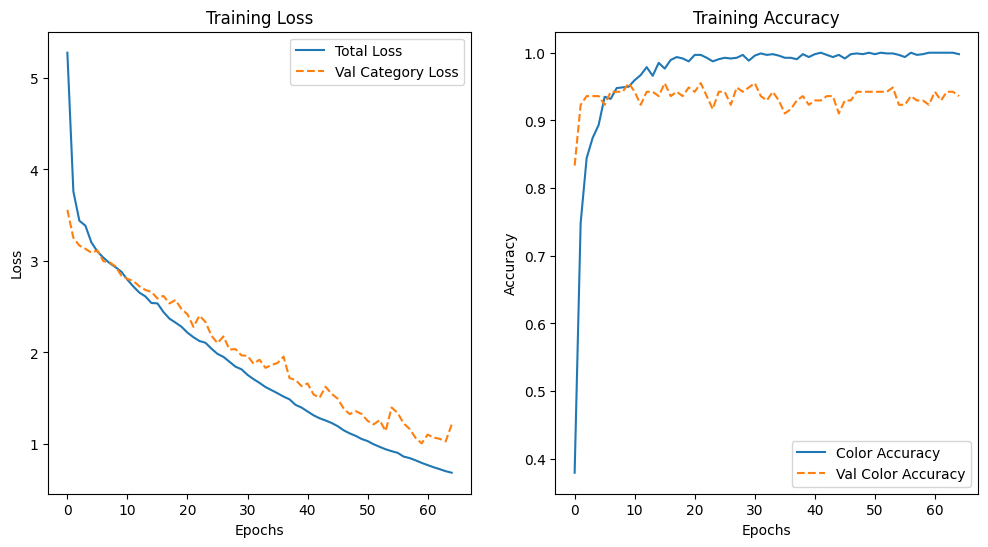

In [9]:
# View Color Model Metrics
score = color_model.evaluate(xtrain_warna,ytrain_warna)
print("Loss and metrics for each output:", score)
print('Total Test Loss:', score[0])
print('Color Accuracy:', score[1])

score = color_model.evaluate(xval_warna,yval_warna)
print("Loss and metrics for each output:", score)
print('Total Vall Loss:', score[0])
print('Val Color Accuracy:', score[1])

totall = len(history.history['loss'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(totall), history.history['loss'], label='Total Loss')
plt.plot(range(totall), history.history['val_loss'], label='Val Category Loss', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(totall), history.history['accuracy'], label='Color Accuracy')
plt.plot(range(totall), history.history['val_accuracy'], label='Val Color Accuracy', linestyle='--')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()

In [10]:
color_model.save('./models/color.h5', include_optimizer=True)